# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Обучим на имеющихся данных несколько моделей с разными гиперпараметрами. Проверим их качество на валидационной выборке и выберем лучшую из тех, чья доля правильных ответов превысит 0,75.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


In [1]:
# импортируем необходимые библиотеки и методы
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.dummy import DummyClassifier

## Откройте и изучите файл

In [2]:
# откроем файл и посмотрим первые 5 строк
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# посмотрим основную информацию об имеющемся наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


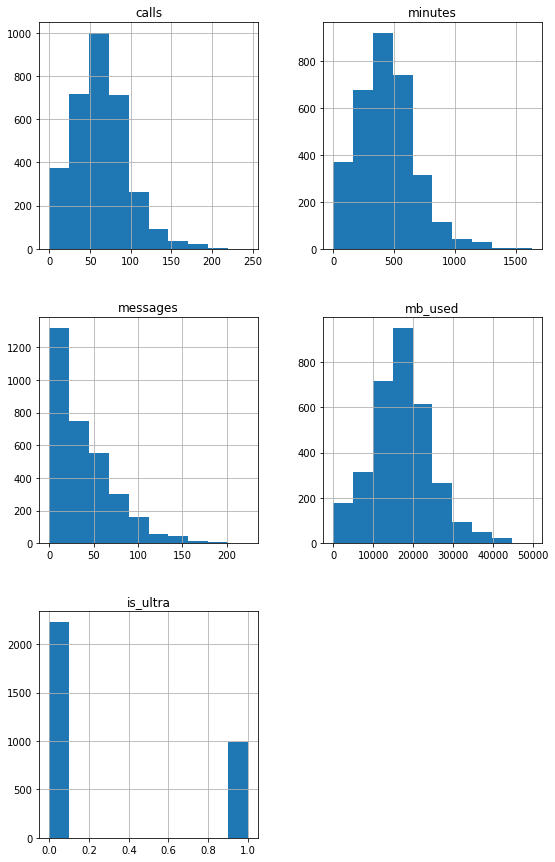

In [4]:
# посмотрим, что собой представляют числовые значения имеющихся характеристик данных
data.hist(figsize=(9, 15));

In [5]:
# посмотрим, как распределились значения количественных признаков
data.loc[:, 'calls':'mb_used'].describe()

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836
std,33.236368,234.569872,36.148326,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500
50%,62.000000,430.600000,30.000000,16943.235000
75%,82.000000,571.927500,57.000000,21424.700000
max,244.000000,1632.060000,224.000000,49745.730000


### Вывод

В датасете представлена информация о 3214 пользователях. Данные прошли предобработку, пропусков не содержат.

Среднестатистический пользователь за месяц: совершает 62 звонка, тратит на разговоры 430 минут, отправляет 30 сообщений и тратит 16 Гб интернет-траффика.

Пользователи выбирают тариф «Смарт» более чем в 2 раза чаще, чем тариф «Ультра».

## Разбейте данные на выборки

### Разделим исходные данные на обучающую, валидационную и тестовую выборки

Разобьем данные на три части – обучающую выборку, валидационную и тестовую в отношении 3:1:1. 

Сначала отделим 60% в качестве обучающего набора, затем оставшиеся данные разделим пополам.

Так как в наших данных тариф «Смарт» встречается более чем в 2 раза чаще, чем тариф «Ультра», передадим функции train_test_split столбец «is_ultra» в качестве значения параметра stratify, чтобы это соотношение сохранилось после разделения данных на две выборки

In [6]:
data_train, data_rest = train_test_split(
    data,
    test_size=0.4,
    random_state=12345,
    stratify=data['is_ultra']
)

In [7]:
# убедимся в правильности разбиения
data.shape[0], data_train.shape[0], data_rest.shape[0]

(3214, 1928, 1286)

In [8]:
# проверим соотношения значений 0 и 1 в столбце 'is_ultra' в исходном и в двух получившихся наборах
data['is_ultra'].value_counts()/data.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [9]:
data_train['is_ultra'].value_counts()/data_train.shape[0]

0    0.693465
1    0.306535
Name: is_ultra, dtype: float64

In [10]:
data_rest['is_ultra'].value_counts()/data_rest.shape[0]

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

Соотношение классов 0 (соответствует тарифу «Смарт») и 1 (соответствует тарифу «Ультра») во всех трех наборах сохранилось с точностью до трех знаков после запятой.

Теперь разобьем data_rest на валидационную и тестовую выборки.

In [11]:
data_valid, data_test = train_test_split(
    data_rest,
    test_size=0.5,
    random_state=12345,
    stratify=data_rest['is_ultra']
)

In [12]:
# проверим, соотношения значений 0 и 1 в столбце 'is_ultra' в валидационной и тестовой выборках
# соответствуют превоначальным
data_valid['is_ultra'].value_counts()/data_valid.shape[0]

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

In [13]:
data_test['is_ultra'].value_counts()/data_test.shape[0]

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

Полное соответствие пропорциям из data_rest.

### Разделим обучающие признаки и целевой.

Создадим отдельные переменные для обучающих признаков и целевого признака для каждого из трех наборов данных.

In [14]:
features_train = data_train.drop('is_ultra', axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop('is_ultra', axis=1)
target_valid = data_valid['is_ultra']

features_test = data_test.drop('is_ultra', axis=1)
target_test = data_test['is_ultra']

### Выводы

1. На данном шаге мы разделили исходные данные на три части – обучающую выборку, валидационную и тестовую в отношении 3:1:1. Соотношение данных по разным тарифам при этом сохранилось. 
1. Для каждого набора данных выделили обучающие признаки и целевой в различные переменные.

Можно переходить к настройкам моделей и их обучению.

## Исследуйте модели

Заведем массив, в который будем сохранять лучшие модели каждого вида, если доля их правильных ответов превысит 0,75.

In [15]:
best_models = []

### Дерево решений

Для классификации с использованием дерева решений попробуем различные настройки следующих параметров: глубина дерева и количество характеристик, которые учитываются при поиске лучшего разбиения. 

Посмотрим разные варианты сочетания этих параметров.

In [16]:
# создаем переменные для лучшей на текущий момент модели и ее точности
desision_tree_best_model = None
best_result = 0

print('depth','\t', 'max_feat', '\t', 'accuracy_score')

# перебираем разные комбинации в цикле
for depth in range(1, 6):    
    for test_max_features in [1, 2, 3, 4, 'sqrt', 'log2']:
        
        model = DecisionTreeClassifier(
            random_state=12345, 
            max_depth=depth,
            max_features=test_max_features
        )
        
        # обучаем модель на тренировочных данных
        model.fit(features_train, target_train)
        
        # оцениваем качество модели на валидационной выборке
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        print(depth,'\t', test_max_features, '\t', result)
        
        # сохраняем лучшую на данный момент модель и ее показатели
        if result > best_result:
            best_result = result
            desision_tree_best_model = model
            best_max_features=test_max_features
            best_depth = depth
    print()

print('--------------------------------------------------')
print('best results:')
print(best_depth,'\t', best_max_features, '\t', best_result)

print(f'best model: {desision_tree_best_model}')

# если доля правильных ответов превысит 0,75, сохраним нашу модель в списке лучших 
if best_result >= 0.75:
    best_models.append([desision_tree_best_model, best_result])

depth 	 max_feat 	 accuracy_score
1 	 1 	 0.7527216174183515
1 	 2 	 0.7527216174183515
1 	 3 	 0.7402799377916018
1 	 4 	 0.7402799377916018
1 	 sqrt 	 0.7527216174183515
1 	 log2 	 0.7527216174183515

2 	 1 	 0.7807153965785381
2 	 2 	 0.7527216174183515
2 	 3 	 0.7822706065318819
2 	 4 	 0.7729393468118196
2 	 sqrt 	 0.7527216174183515
2 	 log2 	 0.7527216174183515

3 	 1 	 0.7807153965785381
3 	 2 	 0.7744945567651633
3 	 3 	 0.7869362363919129
3 	 4 	 0.7776049766718507
3 	 sqrt 	 0.7744945567651633
3 	 log2 	 0.7744945567651633

4 	 1 	 0.7807153965785381
4 	 2 	 0.776049766718507
4 	 3 	 0.7667185069984448
4 	 4 	 0.7542768273716952
4 	 sqrt 	 0.776049766718507
4 	 log2 	 0.776049766718507

5 	 1 	 0.7884914463452566
5 	 2 	 0.7822706065318819
5 	 3 	 0.7931570762052877
5 	 4 	 0.7853810264385692
5 	 sqrt 	 0.7822706065318819
5 	 log2 	 0.7822706065318819

--------------------------------------------------
best results:
5 	 3 	 0.7931570762052877
best model: DecisionTreeClassifi

Точность дерева решений превысила порог в 0.75. 

Значения  гиперпараметров: 
- глубина – 5, 
- количество учитываемых при разбиении характеристик – 3.


### Случайный лес

Для классификации методом случайного леса попробуем различные комбинации следующих параметров: 
- количество деревьев в лесу,  
- максимальная глубина деревьев, 
- количество характеристик, которые учитываются при поиске лучшего разбиения

In [17]:
# создаем переменные для лучшей на текущий момент модели и ее точности
random_forest_best_model = None
best_result = 0

print('n_estim', 'depth', '\t', 'max_feat', '\t', 'accuracy_score')

# перебираем разные комбинации в цикле
for estimators in range(50, 101, 10):
    for depth in range(1, 6):
        for test_max_features in [1, 2, 3, 4, 'sqrt', 'log2']:
            
            model = RandomForestClassifier(
                n_estimators=estimators,
                max_depth=depth,
                max_features=test_max_features,
                random_state=12345
            )
            
            # обучаем модель на тренировочных данных
            model.fit(features_train, target_train)
            
            # оцениваем качество модели на валидационной выборке
            predictions = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions)
            print(
                estimators,'\t',  
                depth,'\t', 
                test_max_features, '\t',  
                result
            )   
            # сохраняем лучшую на данный момент модель и ее показатели
            if result > best_result:
                best_result = result
                random_forest_best_model = model
                best_n_estimarots=estimators
                best_depth = depth
                best_max_features = test_max_features
                
    print()
print('--------------------------------------------------')
print('best results:')
print(best_n_estimarots,'\t', best_depth,'\t', best_max_features, '\t', best_result)


print(f'best model: {random_forest_best_model}')

# если доля правильных ответов превысит 0,75, сохраним нашу модель в списке лучших 
if best_result >= 0.75:
    best_models.append([random_forest_best_model, best_result])

n_estim depth 	 max_feat 	 accuracy_score
50 	 1 	 1 	 0.7340590979782271
50 	 1 	 2 	 0.7542768273716952
50 	 1 	 3 	 0.7480559875583204
50 	 1 	 4 	 0.7387247278382582
50 	 1 	 sqrt 	 0.7542768273716952
50 	 1 	 log2 	 0.7542768273716952
50 	 2 	 1 	 0.7744945567651633
50 	 2 	 2 	 0.7947122861586314
50 	 2 	 3 	 0.7838258164852255
50 	 2 	 4 	 0.7822706065318819
50 	 2 	 sqrt 	 0.7947122861586314
50 	 2 	 log2 	 0.7947122861586314
50 	 3 	 1 	 0.7962674961119751
50 	 3 	 2 	 0.7947122861586314
50 	 3 	 3 	 0.7978227060653188
50 	 3 	 4 	 0.7931570762052877
50 	 3 	 sqrt 	 0.7947122861586314
50 	 3 	 log2 	 0.7947122861586314
50 	 4 	 1 	 0.7993779160186625
50 	 4 	 2 	 0.7978227060653188
50 	 4 	 3 	 0.7993779160186625
50 	 4 	 4 	 0.8009331259720062
50 	 4 	 sqrt 	 0.7978227060653188
50 	 4 	 log2 	 0.7978227060653188
50 	 5 	 1 	 0.8055987558320373
50 	 5 	 2 	 0.8009331259720062
50 	 5 	 3 	 0.807153965785381
50 	 5 	 4 	 0.8055987558320373
50 	 5 	 sqrt 	 0.8009331259720062
50 	

Точность случайного леса превысила порог с 0.75. 

Значения  гиперпараметров: 	
- количество деревьев в лесу - 60
- максимальная глубина деревьев - 5
- количество характеристик, которые учитываются при поиске лучшего разбиения - 4


### Логистическая регрессия

Для классификации методом логистической регрессии попробуем различные комбинации следующих параметров: 
- несколько вариантов алгоритмов для решения задачи оптимизации
- несколько вариантов максимального числа итераций для алгоритма


In [18]:
# создаем переменные для лучшей на текущий момент модели и ее точности
logistic_regression_best_model = None
best_result = 0

print('solver','\t','max_iter','\t', 'accuracy_score')

# перебираем разные комбинации в цикле
for test_solver in ['lbfgs', 'liblinear', 'newton-cg']:
    for test_max_iter in range(500, 1001, 100):
        model = LogisticRegression(
            solver=test_solver,
            max_iter=test_max_iter,
            random_state=12345
        )
        
        # обучаем модель на тренировочных данных
        model.fit(features_train, target_train)
        
        # оцениваем качество модели на валидационной выборке
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        print(
            test_solver,'\t', 
            test_max_iter, '\t', 
            result
            )
        
        # сохраняем лучшую на данный момент модель и ее показатели
        if result > best_result:
            best_result = result
            logistic_regression_best_model = model
            best_solvers = test_solver
            best_max_iter = test_max_iter
                        
    print()
print('--------------------------------------------------')
print('best results:')
print(best_solvers,'\t', best_max_iter, '\t', best_result)


print(f'best model: {logistic_regression_best_model}')

# если доля правильных ответов превысит 0,75, сохраним нашу модель в списке лучших 
if best_result >= 0.75:
    best_models.append([logistic_regression_best_model, best_result])

solver 	 max_iter 	 accuracy_score
lbfgs 	 500 	 0.7387247278382582
lbfgs 	 600 	 0.7387247278382582
lbfgs 	 700 	 0.7387247278382582
lbfgs 	 800 	 0.7387247278382582
lbfgs 	 900 	 0.7387247278382582
lbfgs 	 1000 	 0.7387247278382582

liblinear 	 500 	 0.71850699844479
liblinear 	 600 	 0.71850699844479
liblinear 	 700 	 0.71850699844479
liblinear 	 800 	 0.71850699844479
liblinear 	 900 	 0.71850699844479
liblinear 	 1000 	 0.71850699844479

newton-cg 	 500 	 0.7387247278382582
newton-cg 	 600 	 0.7387247278382582
newton-cg 	 700 	 0.7387247278382582
newton-cg 	 800 	 0.7387247278382582
newton-cg 	 900 	 0.7387247278382582
newton-cg 	 1000 	 0.7387247278382582

--------------------------------------------------
best results:
lbfgs 	 500 	 0.7387247278382582
best model: LogisticRegression(max_iter=500, random_state=12345)


Максимальная достигнутая точность модели логистической регрессии не превысила заданного порога в 0,75.

### Дерево решений для регрессии

Предсказания дерева решений для регрессии в задаче классификации можно трактовать как вероятность попадания в тот или иной класс. Применим к предсказаниям операцию округления и так получим разделение на классы. 

Попробуем различные комбинации следующих параметров: 
- функция, измеряющая качество разбиения
- максимальная глубина деревьев, 
- количество характеристик, которые учитываются при поиске лучшего разбиения


In [19]:
# создаем переменные для лучшей на текущий момент модели и ее точности
decision_tree_regressor_best_model = None
best_result = 0

print('criterion', '  ', 'max_depth', 'max_features', '\t', 'accuracy_score')

# перебираем разные комбинации в цикле
for test_criterion in [ 'friedman_mse', 'poisson']:
    for depth in range(1, 6):
        for test_max_features in [1, 2, 3, 4, 'auto', 'sqrt', 'log2']:
            model = DecisionTreeRegressor(
                criterion=test_criterion,
                max_depth=depth,
                max_features=test_max_features,
                random_state=12345
            )
            
            # обучаем модель на тренировочных данных
            model.fit(features_train, target_train)
            
            # оцениваем качество модели на валидационной выборке
            predictions = model.predict(features_valid).round()
            result = accuracy_score(target_valid, predictions)
            print(
                test_criterion,'\t', 
                depth, '\t', 
                test_max_features, '\t', 
                result
                )
            # сохраняем лучшую на данный момент модель и ее показатели
            if result > best_result:
                best_result = result
                decision_tree_regressor_best_model = model
                best_criterion = test_criterion
                best_max_depth = depth
                best_max_features = test_max_features
                        
        print()
print('--------------------------------------------------')
print('best results:')
print(best_criterion,'\t', best_max_depth, '\t', best_max_features, '\t', best_result)


print(f'best model: {decision_tree_regressor_best_model}')

# если доля правильных ответов превысит 0,75, сохраним нашу модель в списке лучших 
if best_result >= 0.75:
    best_models.append([decision_tree_regressor_best_model, best_result])

criterion    max_depth max_features 	 accuracy_score
friedman_mse 	 1 	 1 	 0.7527216174183515
friedman_mse 	 1 	 2 	 0.7527216174183515
friedman_mse 	 1 	 3 	 0.7402799377916018
friedman_mse 	 1 	 4 	 0.7402799377916018
friedman_mse 	 1 	 auto 	 0.7402799377916018
friedman_mse 	 1 	 sqrt 	 0.7527216174183515
friedman_mse 	 1 	 log2 	 0.7527216174183515

friedman_mse 	 2 	 1 	 0.7807153965785381
friedman_mse 	 2 	 2 	 0.7527216174183515
friedman_mse 	 2 	 3 	 0.7822706065318819
friedman_mse 	 2 	 4 	 0.7729393468118196
friedman_mse 	 2 	 auto 	 0.7729393468118196
friedman_mse 	 2 	 sqrt 	 0.7527216174183515
friedman_mse 	 2 	 log2 	 0.7527216174183515

friedman_mse 	 3 	 1 	 0.7807153965785381
friedman_mse 	 3 	 2 	 0.7744945567651633
friedman_mse 	 3 	 3 	 0.7869362363919129
friedman_mse 	 3 	 4 	 0.7776049766718507
friedman_mse 	 3 	 auto 	 0.7776049766718507
friedman_mse 	 3 	 sqrt 	 0.7744945567651633
friedman_mse 	 3 	 log2 	 0.7744945567651633

friedman_mse 	 4 	 1 	 0.7807153965

Точность дерева решений для регрессии превысила порог с 0.75.

Значения  гиперпараметров: 	
- функция, измеряющая качество разбиения - friedman_mse
- максимальная глубина деревьев - 5
- количество характеристик, которые учитываются при поиске лучшего разбиения - 3


### Случайный лес для регресcии

Предсказания случайного леса для регрессии в задаче классификации также можно трактовать как вероятность попадания в тот или иной класс. 

Здесь тоже применим к предсказаниям операцию округления и так получим разделение на классы. 

Попробуем различные комбинации следующих параметров: 
- количество деревьев в лесу, 
- функция, измеряющая качество разбиения, 
- максимальная глубина деревьев, 
- количество характеристик, которые учитываются при поиске лучшего разбиения


In [20]:
# создаем переменные для лучшей на текущий момент модели и ее точности
random_forest_regressor_best_model = None
best_result = 0

print('n_estim','  ', 'criter','\t','depth','\t', 'max_feat', ' ', 'accuracy_score')

# перебираем разные комбинации в цикле
for estimators in range(50, 101, 10):
    for test_criterion in ['friedman_mse', 'poisson']:
        for depth in range(1, 6):
            for test_max_features in [1, 2, 3, 4, 'sqrt', 'log2']:
                model = RandomForestRegressor(
                    n_estimators=estimators,
                    criterion=test_criterion,
                    max_depth=depth,
                    max_features=test_max_features,
                    random_state=12345
                )
                
                # обучаем модель на тренировочных данных
                model.fit(features_train, target_train)
                
                # оцениваем качество модели на валидационной выборке
                predictions = model.predict(features_valid).round()
                result = accuracy_score(target_valid, predictions)
                print(
                    estimators,'\t', 
                    test_criterion, '\t', 
                    depth,'\t', 
                    test_max_features, '\t', 
                    result
                )   
                
                # сохраняем лучшую на данный момент модель и ее показатели
                if result > best_result:
                    best_result = result
                    random_forest_regressor_best_model = model
                    best_n_estimarots=estimators
                    best_criterion=test_criterion
                    best_depth = depth
                    best_max_features = test_max_features
    print()
print('--------------------------------------------------')
print('best results:')
print(best_n_estimarots,'\t', best_criterion, '\t', best_depth,'\t', best_max_features, '\t', best_result)


print(f'best model: {random_forest_regressor_best_model}')

# если доля правильных ответов превысит 0,75, сохраним нашу модель в списке лучших 
if best_result >= 0.75:
    best_models.append([random_forest_regressor_best_model, best_result])

n_estim    criter 	 depth 	 max_feat   accuracy_score
50 	 friedman_mse 	 1 	 1 	 0.7340590979782271
50 	 friedman_mse 	 1 	 2 	 0.7542768273716952
50 	 friedman_mse 	 1 	 3 	 0.7480559875583204
50 	 friedman_mse 	 1 	 4 	 0.7387247278382582
50 	 friedman_mse 	 1 	 sqrt 	 0.7542768273716952
50 	 friedman_mse 	 1 	 log2 	 0.7542768273716952
50 	 friedman_mse 	 2 	 1 	 0.7744945567651633
50 	 friedman_mse 	 2 	 2 	 0.7947122861586314
50 	 friedman_mse 	 2 	 3 	 0.7838258164852255
50 	 friedman_mse 	 2 	 4 	 0.7822706065318819
50 	 friedman_mse 	 2 	 sqrt 	 0.7947122861586314
50 	 friedman_mse 	 2 	 log2 	 0.7947122861586314
50 	 friedman_mse 	 3 	 1 	 0.7962674961119751
50 	 friedman_mse 	 3 	 2 	 0.7947122861586314
50 	 friedman_mse 	 3 	 3 	 0.7978227060653188
50 	 friedman_mse 	 3 	 4 	 0.7931570762052877
50 	 friedman_mse 	 3 	 sqrt 	 0.7947122861586314
50 	 friedman_mse 	 3 	 log2 	 0.7947122861586314
50 	 friedman_mse 	 4 	 1 	 0.7993779160186625
50 	 friedman_mse 	 4 	 2 	 0.79782

Точность случайного леса для регрессии превысила порог с 0.75. 

Значения гиперпараметров: 
- количество деревьев в лесу - 60
- функция, измеряющая качество разбиения - friedman_mse 	
- максимальная глубина деревьев - 5
- количество характеристик, которые учитываются при поиске лучшего разбиения - 4

### Линейная регрессия

Предсказания модели линейной регрессии в задаче классификации также можно трактовать как вероятность попадания в тот или иной класс. 

Здесь тоже применим к предсказаниям операцию округления и так получим разделение на классы

In [21]:
# создаем переменные для лучшей на текущий момент модели и ее точности
linear_regression_best_model = None
best_result = 0

print('fit_intercept','\t','positive', '\t', 'accuracy_score')

# перебираем разные комбинации в цикле
for test_fit_intercept in [True, False]:
    for test_positive in [True, False]:
        model = LinearRegression(
            fit_intercept=test_fit_intercept, 
            positive=test_positive
        )
        
        # обучаем модель на тренировочных данных
        model.fit(features_train, target_train)
        
        # оцениваем качество модели на валидационной выборке
        predictions = model.predict(features_valid).round()
        result = accuracy_score(target_valid, predictions)
        print(test_fit_intercept,'\t','\t',test_positive, '\t','\t', result)
        
        # сохраняем лучшую на данный момент модель и ее показатели
        if result > best_result:
            best_result = result
            linear_regression_best_model = model
            best_fit_intercept=test_fit_intercept
            best_positive=test_positive
            
print()
print('--------------------------------------------------')
print('best results:')
print(best_fit_intercept,'\t', best_positive, '\t', best_result)


print(f'best model: {linear_regression_best_model}')

# если доля правильных ответов превысит 0,75, сохраним нашу модель в списке лучших 
if best_result >= 0.75:
    best_models.append([linear_regression_best_model, best_result])

fit_intercept 	 positive 	 accuracy_score
True 	 	 True 	 	 0.7325038880248833
True 	 	 False 	 	 0.7325038880248833
False 	 	 True 	 	 0.7293934681181959
False 	 	 False 	 	 0.7293934681181959

--------------------------------------------------
best results:
True 	 True 	 0.7325038880248833
best model: LinearRegression(positive=True)


Максимальная достигнутая точность модели линейной регрессии не превысила заданного порога в 0,75.

### Выводы

In [22]:
# выведем список моделей, которые достигли нужной нам точности предсказаний
best_models

[[DecisionTreeClassifier(max_depth=5, max_features=3, random_state=12345),
  0.7931570762052877],
 [RandomForestClassifier(max_depth=5, max_features=4, n_estimators=60,
                         random_state=12345),
  0.8133748055987559],
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=3,
                        random_state=12345),
  0.7931570762052877],
 [RandomForestRegressor(criterion='friedman_mse', max_depth=5, max_features=4,
                        n_estimators=60, random_state=12345),
  0.8133748055987559]]

**Выводы**

1. Мы настроили параметры и обучили 6 моделей: решающее дерево, случайный лес, логистическую регрессию, дерево решений для регрессии, случайный лес для регрессии и линейную регрессию. 


2. Из них заданный порог точности не преодолели только модели логистической и линейной регрессии.


3. Лучшее значение точности модели у случайного леса - 0.813.


## Проверьте модель на тестовой выборке

In [23]:
# создадим переменные для лучшей модели
best_model = None
best_result = 0

for test_model in best_models:
    # предсказания модели на тестовых характеристиках
    predictions = test_model[0].predict(features_test).round()
    
    # вычисляем точность
    result = accuracy_score(target_test, predictions)
    print(test_model[0])
    print('точность на валидационной выборке', test_model[1])
    print('точность на тестовой выборке', result)
    
    if result > best_result:
        best_model = test_model[0]
        best_result = result
    print()
print('------------------------------')
print('best model')
print(best_model, best_result)

DecisionTreeClassifier(max_depth=5, max_features=3, random_state=12345)
точность на валидационной выборке 0.7931570762052877
точность на тестовой выборке 0.80248833592535

RandomForestClassifier(max_depth=5, max_features=4, n_estimators=60,
                       random_state=12345)
точность на валидационной выборке 0.8133748055987559
точность на тестовой выборке 0.8211508553654744

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=3,
                      random_state=12345)
точность на валидационной выборке 0.7931570762052877
точность на тестовой выборке 0.80248833592535

RandomForestRegressor(criterion='friedman_mse', max_depth=5, max_features=4,
                      n_estimators=60, random_state=12345)
точность на валидационной выборке 0.8133748055987559
точность на тестовой выборке 0.8211508553654744

------------------------------
best model
RandomForestClassifier(max_depth=5, max_features=4, n_estimators=60,
                       random_state=12345) 0.8

### Выводы

- При проверке <u>на тестовой выборке все модели показали более высокие результаты</u>, чем на этапе валидационной проверки.

- **Самой точной оказалась модель** классификации с помощью **случайного леса**: точность - 0.821.

## Улучшение модели случайного леса

Попробуем улучшить модель случайного леса. Обучим ее на объединении тренировочной и валидационной выборок

In [24]:
# объединим переменные с обучающими признаками для тренировочной и валидационной выборок
features_train_new = pd.concat([features_train, features_valid])
features_train.shape[0] + features_valid.shape[0] == features_train_new.shape[0]

True

In [25]:
# объединим переменные с целевым признаком для тренировочной и валидационной выборок
target_train_new = pd.concat([target_train, target_valid])
target_train.shape[0] + target_valid.shape[0] == target_train_new.shape[0]

True

In [26]:
# проверим, сохранилось ли соотношение классов
target_train_new.value_counts()/target_train_new.shape[0]

0    0.693504
1    0.306496
Name: is_ultra, dtype: float64

In [27]:
# обучим модель на объединенных данных
model = RandomForestClassifier(
    max_depth=5, 
    max_features=4, 
    n_estimators=60,
    random_state=12345
)

# проверим точность предсказаний
model.fit(features_train_new, target_train_new)
predictions = model.predict(features_test)
accuracy_score(predictions, target_test)

0.8242612752721618

После обучения модели случайного леса на большем количестве данных, точность модели повысилась до 0,824.

## (бонус) Проверьте модели на адекватность

Сравним результат с наивным прогнозом, когда для всех элементов будем делать прогноз по самому частотному классу. То есть доля самого частотного класса в выборке и будет качеством такой модели (так как такие позиции будут спрогнозированы верно). Наша модель будет адекватной, если ее качество будет выше качества наивного прогноза.

Для проверки используем DummyClassifier из ScikitLearn. В качестве стратегии выберем most_frequent, то есть метод predict будет всегда возвращать самый частотный класс, который выделит на тренировочных данных (в данном случае это 0, что соответствует тарифу «Смарт»).

In [28]:
# обучим модель на тренировочных данных и вычислим ее точность на тестовых.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)

predictions = dummy_clf.predict(features_test)
accuracy_score(target_test, predictions)

0.6936236391912908

### Вывод

Показатели точности для всех четырех моделей превышают 0.693. Следовательно, все четыре модели являются адекватными.

## Общий вывод

1. Оператор мобильной связи «Мегалайн» хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы, в общей сложности о 3214 пользователях. Данные прошли предобработку, пропусков не содержат. Пользователи выбирают тариф «Смарт» более чем в 2 раза чаще, чем тариф «Ультра».

2. Мы разделили исходные данные на три части – обучающую выборку, валидационную и тестовую в отношении 3:1:1. Соотношение данных по разным тарифам при этом сохранилось. 

3. Мы настроили параметры и обучили 6 моделей: 
- решающее дерево, 
- случайный лес, 
- логистическую регрессию, 
- дерево решений для регрессии, 
- случайный лес для регрессии 
- линейную регрессию. 
4. Из этих моделей заданный в 0,75 порог точности преодолели:
- решающее дерево (0.79), 
- случайный лес (0.81), 
- дерево решений для регрессии (0.79), 
- случайный лес для регрессии (0.81). 
 
**Лучшее значение точности модели у случайного леса - 0.813**.

5. При проверке на тестовой выборке все модели показали более высокие результаты, чем на этапе валидационной проверки.
**Самой точной** снова оказалась модель классификации с помощью **случайного леса: точность - 0.821**.

6. Удалось еще повысить точность модели случайного леса до 0.824 за счет обучения ее на объединении тренировочной и валидационной выборок.

7. Адекватность моделей проверялась с помощью DummyClassifier, настроенного так, чтобы всегда возвращать самый частотный класс. Точность такой модели составила 0.693. Показатели точности для всех четырех моделей превышают этот уровень. Следовательно, все четыре модели являются адекватными.


**Таким образом, лучшей моделью является модель RandomForestClassifier со следующими значениями гиперпараметров**: 
- количество деревьев - 60
- максимальная глубина деревьев - 5
- количество характеристик, которые учитываются при поиске лучшего разбиения – 4.

**На тестовых данных модель достигла точности 0.824**.
